<h1> Análisis Avanzado de Partidas – Torneo de Grandes Maestros</h1>
<h3> <strong>Segunda parte:</strong> Descifrando el juego de los genios</h3>
<p> Realizaremos un estudio de ocho grandes maestros de reconocido prestigio internacional. Tomaremos las partidas de todos ellos de los últimos seis meses. </p>

<table>
  <tr>
    <td colspan="2" rowspan="2" style="vertical-align: top;">
      <img src="./fotos/Esquema_2.png" width="450"/>
    </td>
    <td align="center">
      <img src="./fotos/1_Carlsen.jpeg" width="100"/><br/>
      Carlsen, M
    </td>
    <td align="center">
      <img src="./fotos/2_Nakamura.jpeg" width="100"/><br/>
      Nakamura, Hi
    </td>
    <td align="center">
      <img src="./fotos/3_Bortnyk.jpeg" width="100"/><br/>
      Bortnyk, O
    </td>
    <td align="center">
      <img src="./fotos/4_Bluebaum.png" width="100"/><br/>
      Bluebaum, M
    </td>
  </tr>
  <tr>
    <td align="center">
      <img src="./fotos/5_Zhigalko.jpeg" width="100"/><br/>
      Zhigalko, S
    </td>
    <td align="center">
      <img src="./fotos/6_Vlassov.jpg" width="100"/><br/>
      Vlassov, N
    </td>
    <td align="center">
      <img src="./fotos/7_Andreikin.png" width="100"/><br/>
      Andreikin, D
    </td>
    <td align="center">
      <img src="./fotos/8_Rustemov.jpeg" width="100"/><br/>
      Rustemov, A
    </td>
  </tr>
</table>


## 0. Carga de librerías necesarias

In [1]:
# === Módulos del sistema ===
import os
import builtins
import datetime
import re

# === Manejo de datos ===
import pandas as pd
import numpy as np
import statistics

# === Visualización ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

# === Interpolación y estadísticas ===
from scipy.interpolate import make_interp_spline

# === Jupyter Notebook ===
from IPython.display import display, Markdown

# === Lectura de partidas de ajedrez ===
import chess.pgn

# === PySpark ===
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import (
    col, when, count, mean, stddev, min, max, round, sum, expr,
    to_timestamp, udf
)

## 1. Creación de la sesión de Spark y carga del dataframe

In [2]:
spark = (
    SparkSession.builder
    .appName("Analisis_jugadores")
    .master("yarn")  
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/14 09:59:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/14 09:59:23 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
# Leer todos los archivos .parquet de la carpeta en un único DataFrame
ruta_parquets_hdfs = "hdfs:///user/ajedrez/partidas/analizadas_grupo"
# Se pone en caché pues vamos a realizar muchas operaciones sobre él
df = spark.read.parquet(ruta_parquets_hdfs).cache()

25/07/14 10:00:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
df.count()  # se materializa en memoria
# Comprobar número de partidas cargadas
print(f"Filas totales: {df.count()}")

Filas totales: 6013


## 2. Rendimiento general de cada jugador

In [5]:
# Lista de jugadores objetivo
jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
]

# Filtrar partidas de jugadores objetivo
df_objetivo = df.filter(col("jugador").isin(jugadores_objetivo))

# Separar por color
df_blancas = df_objetivo.filter(col("color") == "W")
df_negras = df_objetivo.filter(col("color") == "B")

### 2.1 Rendimiento global (ambos colores)

In [6]:
# Crear columnas auxiliares para cada resultado
df_resultados = df_objetivo.withColumn("victoria", when(col("resultados") == 1.0, 1).otherwise(0)) \
                           .withColumn("empate", when(col("resultados") == 0.5, 1).otherwise(0)) \
                           .withColumn("derrota", when(col("resultados") == 0.0, 1).otherwise(0))

# Agrupar y calcular estadísticas
estadisticas = df_resultados.groupBy("jugador").agg(
    count("*").alias("Partidas"),
    round(mean("resultados"), 2).alias("Promedio de Resultado"),
    round(100 * sum("victoria") / count("*"), 2).alias("Victorias (%)"),
    round(100 * sum("empate") / count("*"), 2).alias("Tablas (%)"),
    round(100 * sum("derrota") / count("*"), 2).alias("Derrotas (%)")
)

# Ordenar por Promedio de Resultado
estadisticas_ordenadas = estadisticas.orderBy(col("Promedio de Resultado").desc())

# Mostrar resultados
estadisticas_ordenadas.show()


+----------------+--------+---------------------+-------------+----------+------------+
|         jugador|Partidas|Promedio de Resultado|Victorias (%)|Tablas (%)|Derrotas (%)|
+----------------+--------+---------------------+-------------+----------+------------+
|       Carlsen,M|     300|                 0.83|        74.67|     15.67|        9.67|
|     Nakamura,Hi|     324|                  0.8|        73.15|      14.2|       12.65|
|Bortnyk,Olexandr|     452|                 0.76|        69.91|     11.73|       18.36|
|     Andreikin,D|     192|                 0.76|        67.71|     17.19|        15.1|
|      Bluebaum,M|     426|                 0.75|        63.62|     21.83|       14.55|
|      Zhigalko,S|     390|                 0.73|        68.21|      9.49|       22.31|
|      Rustemov,A|     482|                 0.65|        56.02|     17.43|       26.56|
|       Vlassov,N|     481|                 0.55|        49.48|     11.64|       38.88|
+----------------+--------+-----

### 2.2 Rendimiento global (por color)

In [7]:
# Función auxiliar para calcular estadísticas por grupo
def calcular_estadisticas_por_color(df_color):
    df_aux = df_color.withColumn("victoria", when(col("resultados") == 1.0, 1).otherwise(0)) \
                     .withColumn("empate", when(col("resultados") == 0.5, 1).otherwise(0)) \
                     .withColumn("derrota", when(col("resultados") == 0.0, 1).otherwise(0))

    estadisticas = df_aux.groupBy("jugador").agg(
        count("*").alias("Partidas"),
        round(mean("resultados"), 2).alias("Promedio de Resultado"),
        round(100 * sum("victoria") / count("*"), 2).alias("Victorias (%)"),
        round(100 * sum("empate") / count("*"), 2).alias("Tablas (%)"),
        round(100 * sum("derrota") / count("*"), 2).alias("Derrotas (%)")
    )

    return estadisticas.orderBy(col("Promedio de Resultado").desc())

# Calcular estadísticas por color
estadisticas_blancas = calcular_estadisticas_por_color(df_blancas)
estadisticas_negras = calcular_estadisticas_por_color(df_negras)

# Mostrar resultados
print("Estadísticas con blancas:")
estadisticas_blancas.show(truncate=False)

print("\nEstadísticas con negras:")
estadisticas_negras.show(truncate=False)

Estadísticas con blancas:
+----------------+--------+---------------------+-------------+----------+------------+
|jugador         |Partidas|Promedio de Resultado|Victorias (%)|Tablas (%)|Derrotas (%)|
+----------------+--------+---------------------+-------------+----------+------------+
|Carlsen,M       |148     |0.84                 |79.05        |10.14     |10.81       |
|Nakamura,Hi     |165     |0.82                 |73.94        |15.76     |10.3        |
|Andreikin,D     |102     |0.79                 |71.57        |15.69     |12.75       |
|Bortnyk,Olexandr|236     |0.78                 |72.03        |11.02     |16.95       |
|Bluebaum,M      |211     |0.78                 |69.67        |16.59     |13.74       |
|Zhigalko,S      |196     |0.72                 |67.35        |10.2      |22.45       |
|Rustemov,A      |243     |0.7                  |61.32        |16.46     |22.22       |
|Vlassov,N       |243     |0.58                 |51.44        |12.35     |36.21       |
+-----

### 2.3 Rendimiento general de cada jugador por color (decaimiento exponencial)
Refleja mejor el "estado de forma" actual.

- Se asigna como fecha de referencia la más reciente.
- Se calcula la diferencia en `días` entre la fecha de la partida y la fecha de referencia.
- Se devuelve una lista de pesos [$w_1$, $w_2$,$\ldots$] donde cada peso es $$w_i=e^{-\lambda \cdot \text{días} }$$
  donde $\lambda$ es el factor de decaimiento que se quiera indicar ($\lambda=0$ no influyen las fechas). 
- La lista de pesos se devuelve normalizada ($w_i\in[0,1]$ y $\sum w_i=1$).

In [8]:
# Parámetro de decaimiento
lambda_ = 0.01

# Filtrar por color
df_blancas = df_objetivo.filter(col("color") == "W")
df_negras = df_objetivo.filter(col("color") == "B")

# Definir función para aplicar en Pandas
def calcular_estadisticas_ponderadas(grupo: pd.DataFrame) -> pd.DataFrame:
    if grupo.empty:
        return pd.DataFrame(columns=["jugador", "Partidas", "Promedio Ponderado", "Victorias (%)", "Tablas (%)", "Derrotas (%)"])

    fechas = pd.to_datetime(grupo["fechas"])
    fecha_max = fechas.max()
    dias = (fecha_max - fechas).dt.days
    pesos = np.exp(-lambda_ * dias)
    pesos /= pesos.sum()

    resultados = grupo["resultados"]
    prom_ponderado = np.average(resultados, weights=pesos)
    victorias = ((resultados == 1.0) * pesos).sum()
    empates = ((resultados == 0.5) * pesos).sum()
    derrotas = ((resultados == 0.0) * pesos).sum()

    return pd.DataFrame([{
        "jugador": grupo["jugador"].iloc[0],
        "Partidas": len(grupo),
        "Promedio Ponderado": builtins.round(prom_ponderado, 2),
        "Victorias (%)": builtins.round(100 * victorias, 2),
        "Tablas (%)": builtins.round(100 * empates, 2),
        "Derrotas (%)": builtins.round(100 * derrotas, 2)
    }])

# Definir schema de salida
schema = StructType([
    StructField("jugador", StringType()),
    StructField("Partidas", IntegerType()),
    StructField("Promedio Ponderado", DoubleType()),
    StructField("Victorias (%)", DoubleType()),
    StructField("Tablas (%)", DoubleType()),
    StructField("Derrotas (%)", DoubleType())
])

# Aplicar por jugador con applyInPandas
estadisticas_blancas_pond = df_blancas.groupBy("jugador").applyInPandas(calcular_estadisticas_ponderadas, schema)
estadisticas_negras_pond = df_negras.groupBy("jugador").applyInPandas(calcular_estadisticas_ponderadas, schema)

# Ordenar
estadisticas_blancas_pond = estadisticas_blancas_pond.orderBy(col("Promedio Ponderado").desc())
estadisticas_negras_pond = estadisticas_negras_pond.orderBy(col("Promedio Ponderado").desc())

# Mostrar
print("Estadísticas con blancas (ponderadas por fecha):")
estadisticas_blancas_pond.show(truncate=False)

print("Estadísticas con negras (ponderadas por fecha):")
estadisticas_negras_pond.show(truncate=False)


Estadísticas con blancas (ponderadas por fecha):


+----------------+--------+------------------+-------------+----------+------------+
|jugador         |Partidas|Promedio Ponderado|Victorias (%)|Tablas (%)|Derrotas (%)|
+----------------+--------+------------------+-------------+----------+------------+
|Nakamura,Hi     |165     |0.84              |75.32        |16.5      |8.18        |
|Carlsen,M       |148     |0.82              |77.56        |9.08      |13.36       |
|Bluebaum,M      |211     |0.79              |70.77        |15.8      |13.43       |
|Bortnyk,Olexandr|236     |0.79              |74.29        |9.91      |15.8        |
|Andreikin,D     |102     |0.78              |71.02        |14.69     |14.29       |
|Zhigalko,S      |196     |0.73              |67.47        |10.27     |22.26       |
|Rustemov,A      |243     |0.69              |60.5         |17.65     |21.85       |
|Vlassov,N       |243     |0.55              |49.97        |11.05     |38.98       |
+----------------+--------+------------------+-------------+-----

### 2.4 Gráficas del rendimiento general de cada jugador por color

PySpark no puede generar gráficos directamente. Para graficar, necesitas convertir los datos de Spark a pandas, y luego usar matplotlib, como en local. Por tanto, se procesan los datos en Spark (eficiente y distribuido), convertimos los resultados a pandas (toPandas()) y graficamos localmente en Jupyter con matplotlib.

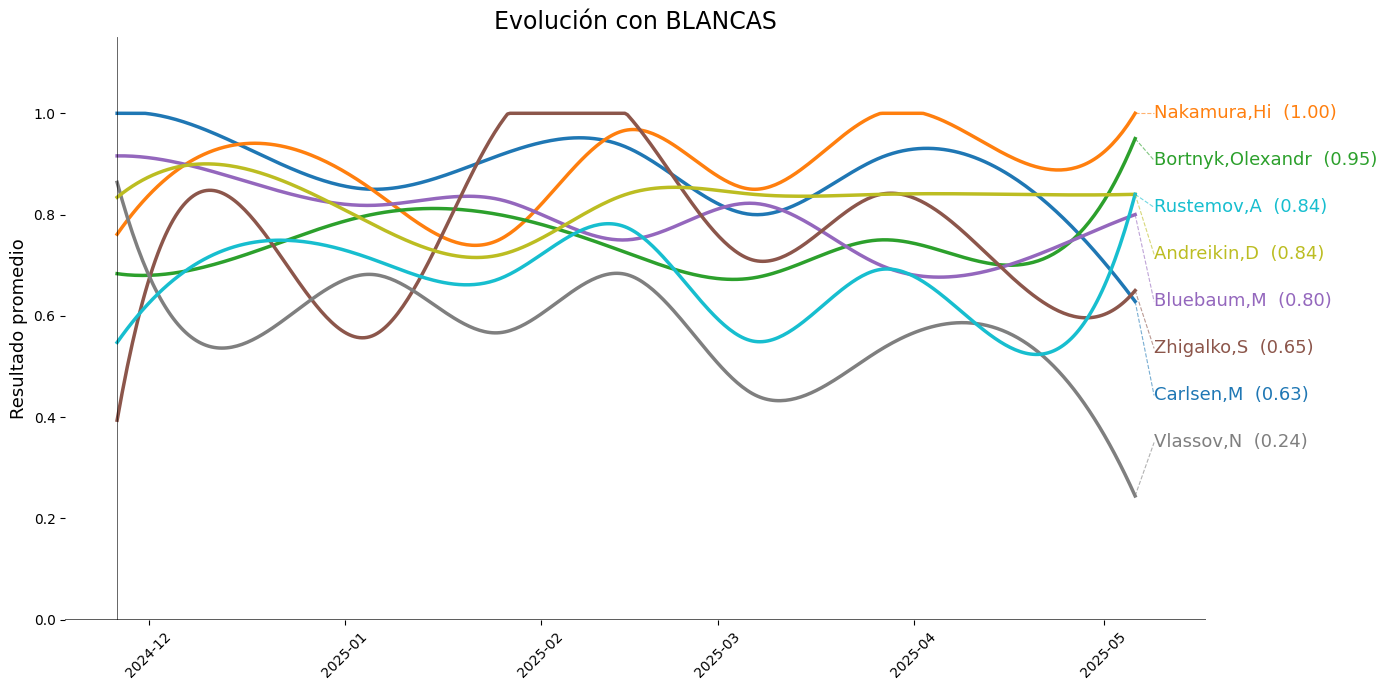

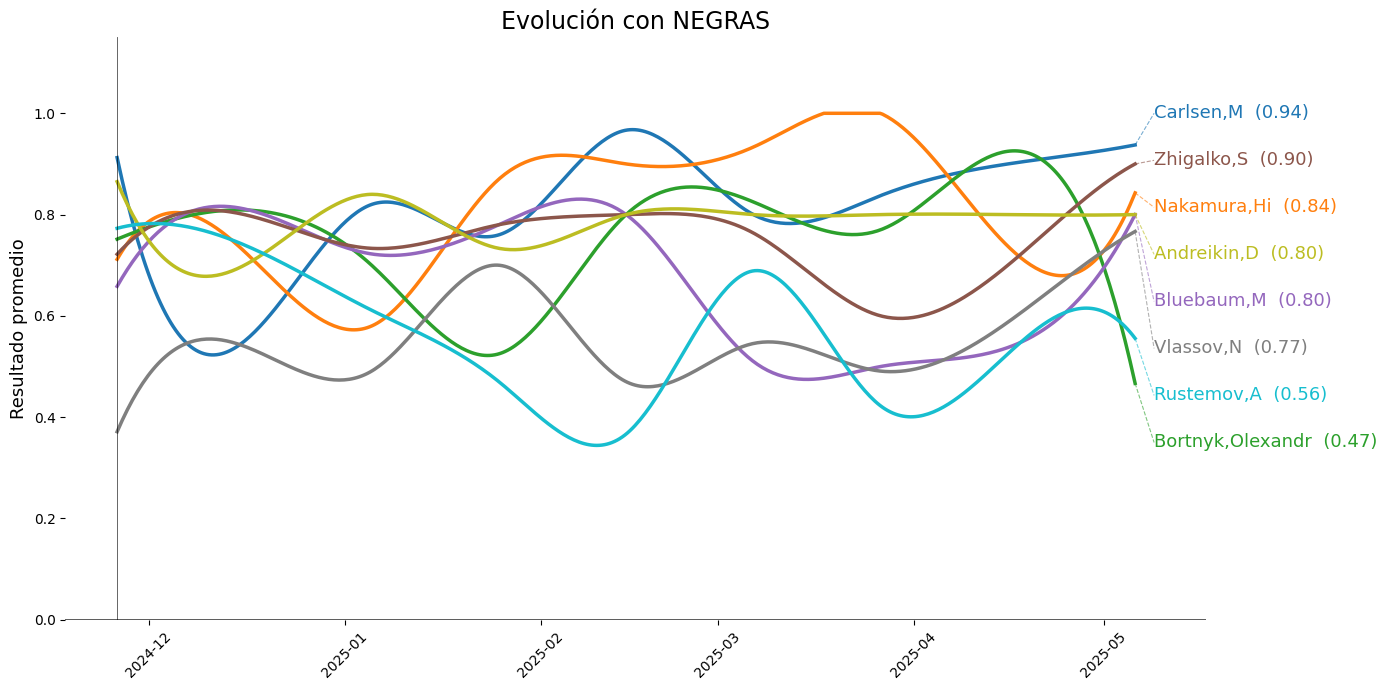

In [9]:
# 1. Filtrar desde Spark y convertir a pandas solo lo necesario
df_blancas_pd = df.filter(
    (col("color") == "W") & col("jugador").isin(jugadores_objetivo)
).orderBy("fechas").toPandas()

df_negras_pd = df.filter(
    (col("color") == "B") & col("jugador").isin(jugadores_objetivo)
).orderBy("fechas").toPandas()

# 2. Función de visualización
colores = plt.colormaps.get_cmap('tab10')

def graficar_resumen_temporal(df_color, titulo):
    fechas_inicio = df_color["fechas"].min()
    fechas_fin = df_color["fechas"].max()
    fechas_referencia = pd.date_range(start=fechas_inicio, end=fechas_fin, periods=9)

    plt.figure(figsize=(14, 7))
    etiquetas = []

    for idx, jugador in enumerate(jugadores_objetivo):
        color = colores(idx / (len(jugadores_objetivo) - 1))
        partidas = df_color[df_color["jugador"] == jugador].copy()
        if partidas.empty:
            continue

        partidas = partidas.sort_values("fechas")
        partidas["media_movil"] = partidas["resultados"].rolling(window=5, min_periods=1).mean()
        promedio_por_dia = partidas.groupby("fechas")["media_movil"].mean()
        media_uniforme = promedio_por_dia.reindex(fechas_referencia, method='nearest').interpolate()

        x = fechas_referencia.astype(np.int64)
        y = media_uniforme.values

        if len(x) >= 4:
            spline = make_interp_spline(x, y, k=3)
            x_nuevo = np.linspace(x.min(), x.max(), 400)
            y_suave = spline(x_nuevo)
            y_suave = np.clip(y_suave, 0, 1)

            fechas_suaves = pd.to_datetime(x_nuevo)

            plt.plot(fechas_suaves, y_suave, linewidth=2.5, color=color)

            etiquetas.append({
                "jugador": jugador,
                "y_real": y_suave[-1],
                "color": color,
                "x_final": fechas_suaves[-1]
            })

    etiquetas = sorted(etiquetas, key=lambda e: e["y_real"])
    y_labels = np.linspace(0.15, 0.8, len(etiquetas)) + 0.2

    for etiqueta, y_label in zip(etiquetas, y_labels):
        plt.plot(
            [etiqueta["x_final"], etiqueta["x_final"] + pd.Timedelta(days=3)],
            [etiqueta["y_real"], y_label],
            color=etiqueta["color"],
            linewidth=0.8,
            linestyle="--",
            alpha=0.6
        )
        valor = f"{etiqueta['y_real']:.2f}"
        plt.text(
            etiqueta["x_final"] + pd.Timedelta(days=3),
            y_label,
            f"{etiqueta['jugador']}  ({valor})",
            fontsize=13,
            color=etiqueta["color"],
            va='center'
        )

    plt.title(titulo, fontsize=17)
    plt.xlabel("", fontsize=13)
    plt.ylabel("Resultado promedio", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylim(0, 1.15)
    plt.grid(False)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.axhline(0, color="black", linewidth=2.0, alpha=0.7)
    plt.axvline(fechas_inicio, color="black", linewidth=0.6, alpha=0.7)
    plt.tight_layout()
    plt.show()

# 3. Graficas por color
graficar_resumen_temporal(df_blancas_pd, "Evolución con BLANCAS")
graficar_resumen_temporal(df_negras_pd, "Evolución con NEGRAS")


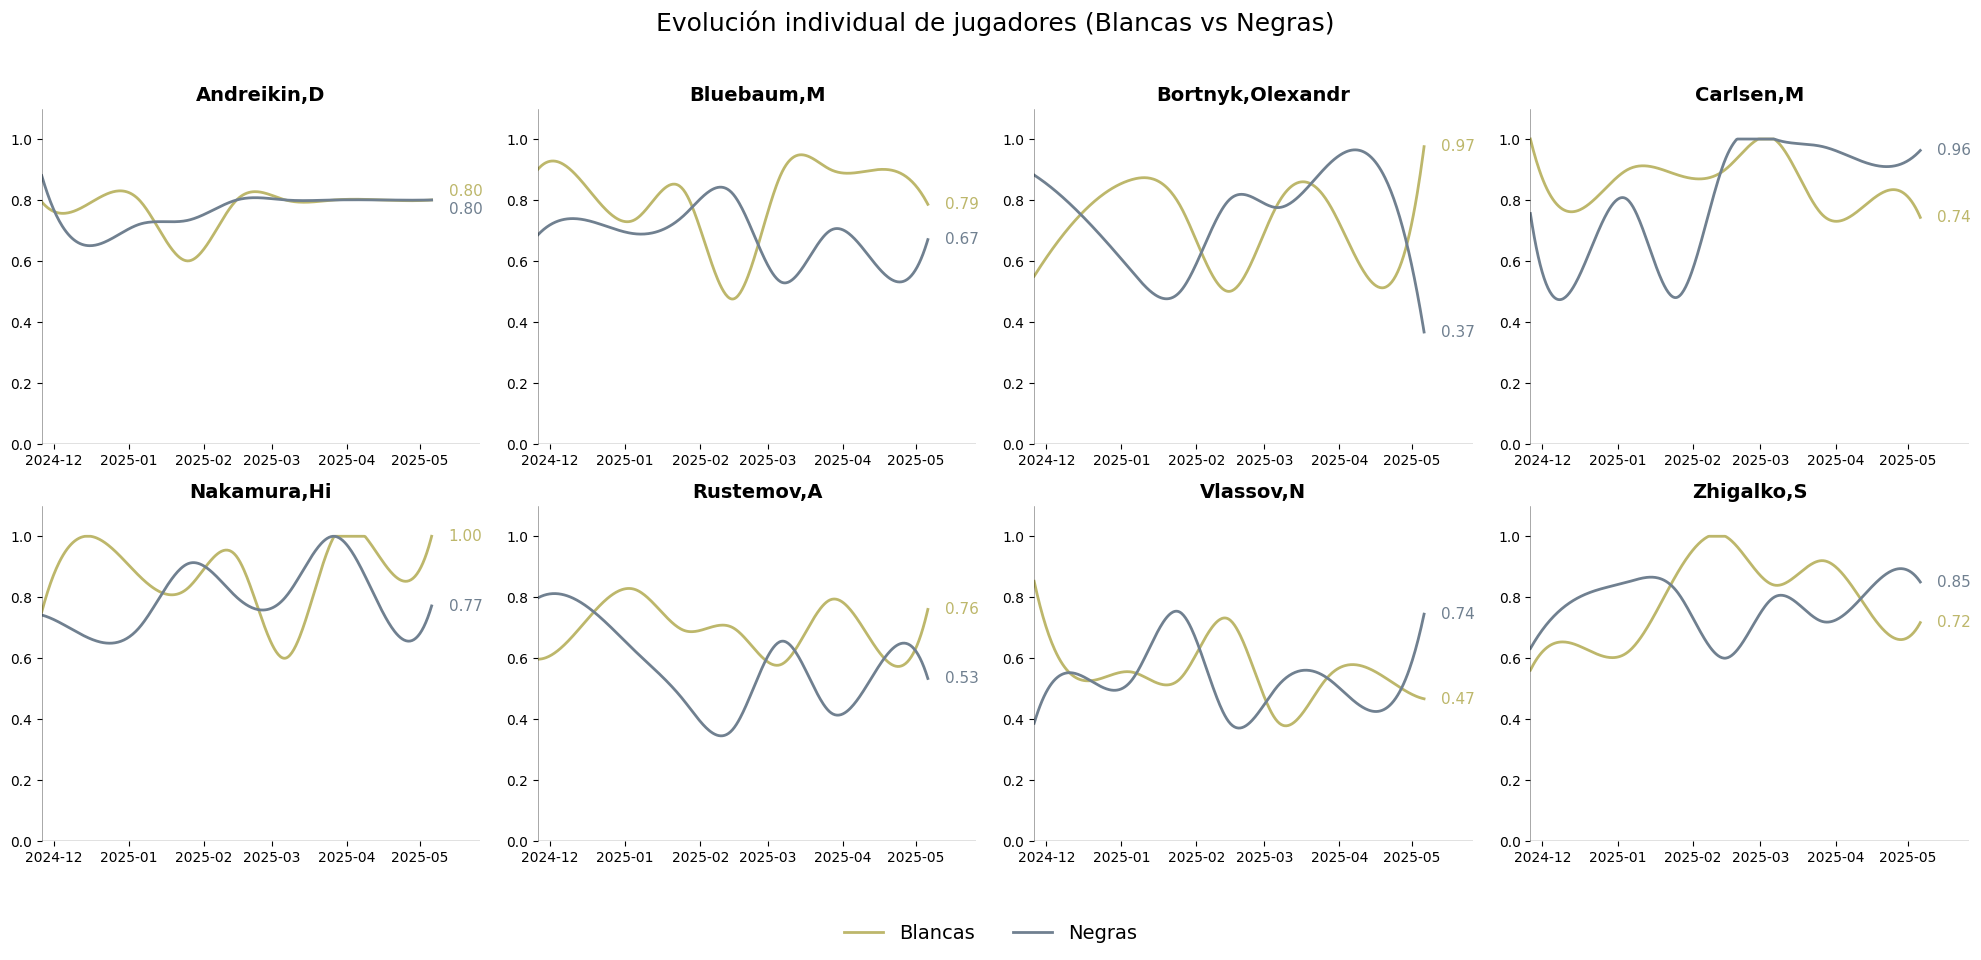

In [10]:
# 1. Preprocesar en Spark
df = df.withColumn("fechas", to_timestamp("fechas"))
jugadores_objetivo = sorted([
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
])

df_objetivo = df.select("jugador", "color", "fechas", "resultados")\
    .filter(col("jugador").isin(jugadores_objetivo))\
    .toPandas()

# 2. Continuar con el código de matplotlib
#df_objetivo["fechas"] = pd.to_datetime(df_objetivo["fechas"])

# Colores para blancas y negras
colores = {"W": "darkkhaki", "B": "slategray"}

# Figura con más espacio entre subplots (2x4)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Más ancho, menos alto
fig.subplots_adjust(hspace=0.4, wspace=0.3)       # Ajuste de separación
axes = axes.flatten()

# Fechas comunes
fechas_inicio = df_objetivo["fechas"].min()
fechas_fin = df_objetivo["fechas"].max()
fechas_referencia = pd.date_range(start=fechas_inicio, end=fechas_fin, periods=9)
x_base = fechas_referencia.astype(np.int64)

for i, jugador in enumerate(jugadores_objetivo):
    ax = axes[i]
    valores_finales = {}

    for color in ["W", "B"]:
        partidas = df_objetivo[(df_objetivo["jugador"] == jugador) & (df_objetivo["color"] == color)].copy()
        if partidas.empty:
            continue

        partidas.sort_values("fechas", inplace=True)
        partidas["media_movil"] = partidas["resultados"].rolling(window=5, min_periods=1).mean()
        promedio_por_dia = partidas.groupby("fechas")["media_movil"].mean()
        media_uniforme = promedio_por_dia.reindex(fechas_referencia, method='nearest').interpolate()

        x = x_base
        y = media_uniforme.values

        if len(x) >= 4:
            spline = make_interp_spline(x, y, k=3)
            x_nuevo = np.linspace(x.min(), x.max(), 400)
            y_suave = spline(x_nuevo)
            y_suave = np.clip(y_suave, 0, 1)
            fechas_suaves = pd.to_datetime(x_nuevo)

            ax.plot(fechas_suaves, y_suave, label=("Blancas" if color == "W" else "Negras"),
                    color=colores[color], linewidth=2)

            valores_finales[color] = (fechas_suaves[-1], y_suave[-1])

    # Mostrar valores finales (etiquetas al final de la curva)
    if "W" in valores_finales and "B" in valores_finales:
        f_w, y_w = valores_finales["W"]
        f_b, y_b = valores_finales["B"]
        diff = abs(y_w - y_b)
        offset = 0.03 if diff < 0.05 else 0.0

        ax.text(f_w + pd.Timedelta(days=7), y_w + offset,
                f"{y_w:.2f}", fontsize=11, color=colores["W"], va='center', ha='left', clip_on=False)
        ax.text(f_b + pd.Timedelta(days=7), y_b - offset,
                f"{y_b:.2f}", fontsize=11, color=colores["B"], va='center', ha='left', clip_on=False)

    elif "W" in valores_finales:
        f, y = valores_finales["W"]
        ax.text(f + pd.Timedelta(days=7), y,
                f"{y:.2f}", fontsize=11, color=colores["W"], va='center', ha='left', clip_on=False)
    elif "B" in valores_finales:
        f, y = valores_finales["B"]
        ax.text(f + pd.Timedelta(days=7), y,
                f"{y:.2f}", fontsize=11, color=colores["B"], va='center', ha='left', clip_on=False)

    # Estética del subplot
    ax.set_title(jugador, fontsize=14, weight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xlim(fechas_inicio, fechas_fin + pd.Timedelta(days=20))
    ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)
    ax.axvline(fechas_inicio, color="black", linewidth=0.4, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Leyenda global
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, frameon=False)

# Título general
plt.suptitle("Evolución individual de jugadores (Blancas vs Negras)", fontsize=18, y=0.95)

# Guardar gráfico
#plt.savefig("evolucion_jugadores.png", dpi=400, bbox_inches='tight')

# Ajuste final
plt.tight_layout(rect=[0, 0.08, 1, 0.93])
plt.show()

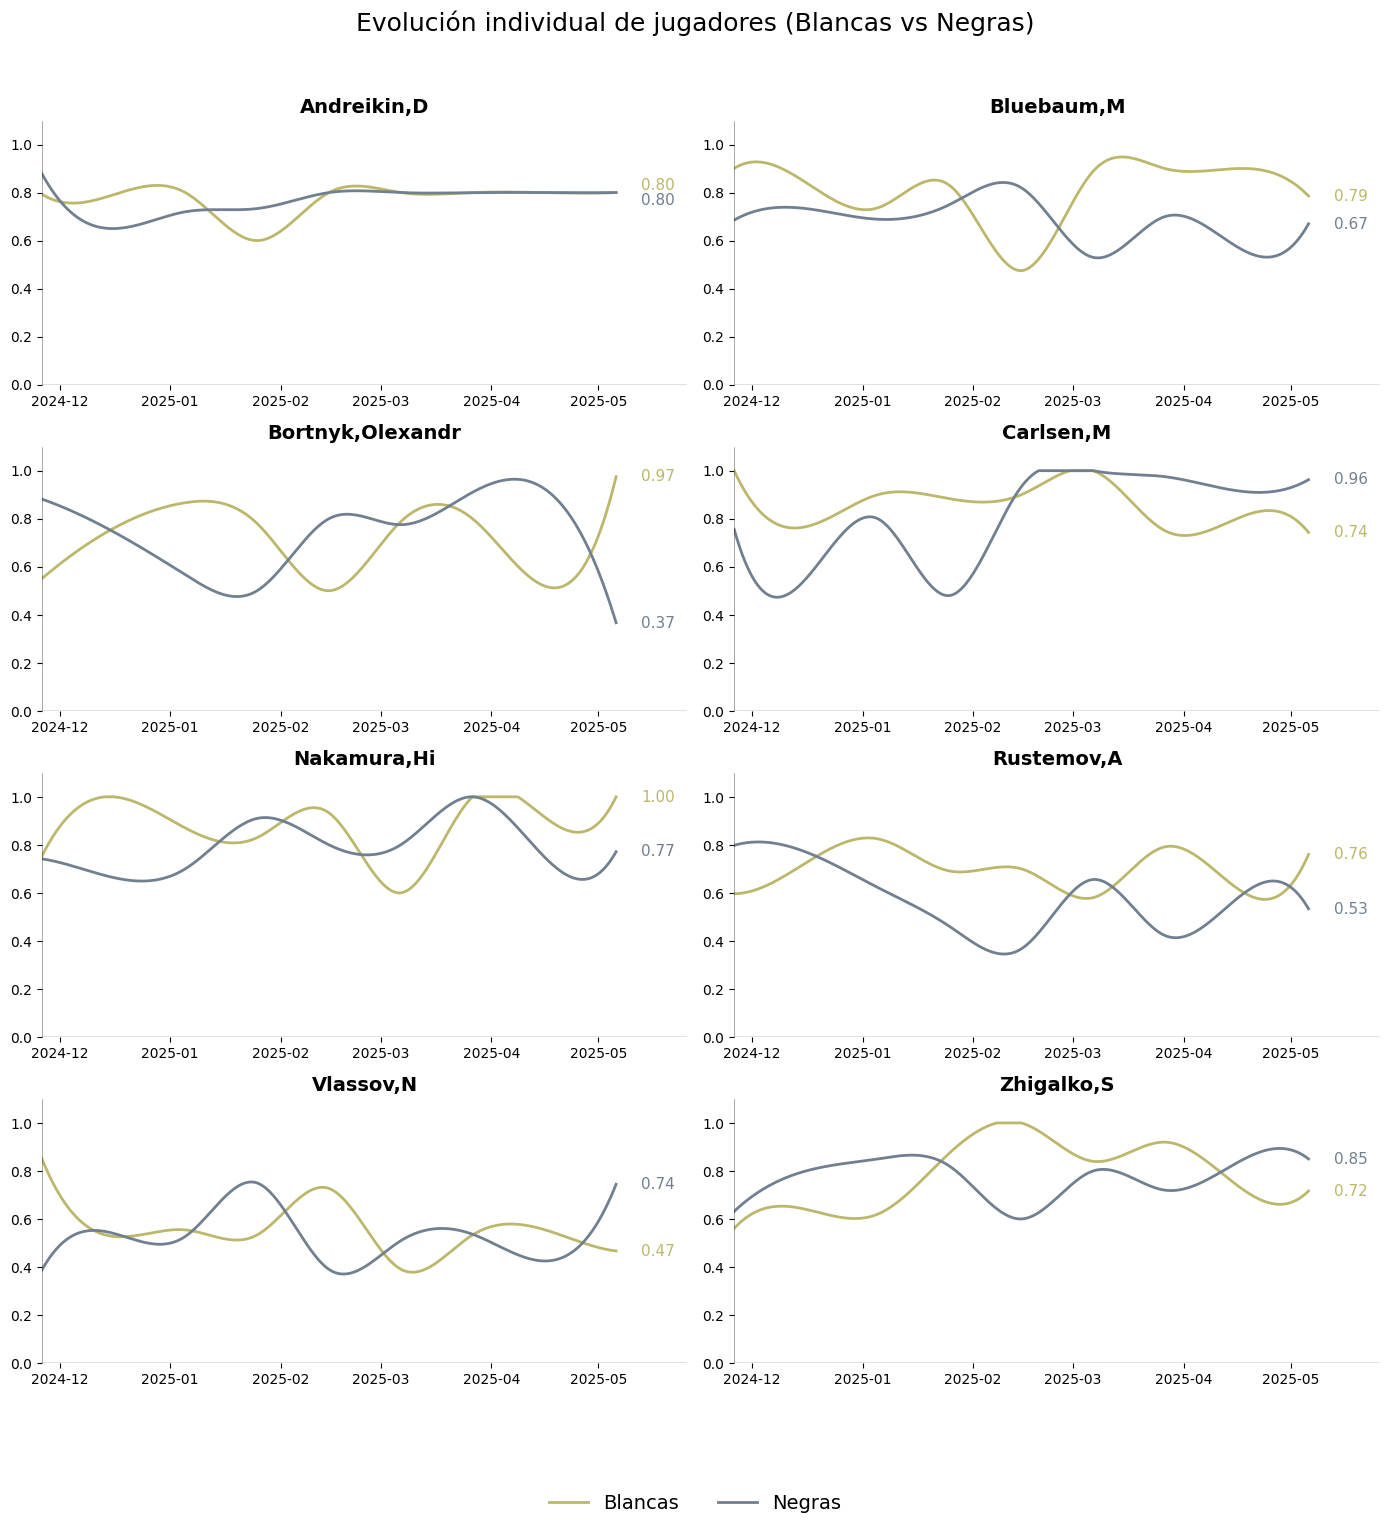

In [11]:
# 1. Preprocesar en Spark
df = df.withColumn("fechas", to_timestamp("fechas"))
jugadores_objetivo = sorted([
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
])

df_objetivo = df.select("jugador", "color", "fechas", "resultados")\
    .filter(col("jugador").isin(jugadores_objetivo))\
    .toPandas()

# 2. Continuar con el código de matplotlib
#df_objetivo["fechas"] = pd.to_datetime(df_objetivo["fechas"])

# Colores para blancas y negras
colores = {"W": "darkkhaki", "B": "slategray"}

# Figura en forma 4x2 (4 filas, 2 columnas)
fig, axes = plt.subplots(4, 2, figsize=(14, 16))  # Más alto, más vertical
fig.subplots_adjust(hspace=0.5, wspace=0.3)       # Ajuste de separación
axes = axes.flatten()


# Fechas comunes
fechas_inicio = df_objetivo["fechas"].min()
fechas_fin = df_objetivo["fechas"].max()
fechas_referencia = pd.date_range(start=fechas_inicio, end=fechas_fin, periods=9)
x_base = fechas_referencia.astype(np.int64)

for i, jugador in enumerate(jugadores_objetivo):
    ax = axes[i]
    valores_finales = {}

    for color in ["W", "B"]:
        partidas = df_objetivo[(df_objetivo["jugador"] == jugador) & (df_objetivo["color"] == color)].copy()
        if partidas.empty:
            continue

        partidas.sort_values("fechas", inplace=True)
        partidas["media_movil"] = partidas["resultados"].rolling(window=5, min_periods=1).mean()
        promedio_por_dia = partidas.groupby("fechas")["media_movil"].mean()
        media_uniforme = promedio_por_dia.reindex(fechas_referencia, method='nearest').interpolate()

        x = x_base
        y = media_uniforme.values

        if len(x) >= 4:
            spline = make_interp_spline(x, y, k=3)
            x_nuevo = np.linspace(x.min(), x.max(), 400)
            y_suave = spline(x_nuevo)
            y_suave = np.clip(y_suave, 0, 1)
            fechas_suaves = pd.to_datetime(x_nuevo)

            ax.plot(fechas_suaves, y_suave, label=("Blancas" if color == "W" else "Negras"),
                    color=colores[color], linewidth=2)

            valores_finales[color] = (fechas_suaves[-1], y_suave[-1])

    # Mostrar valores finales (etiquetas al final de la curva)
    if "W" in valores_finales and "B" in valores_finales:
        f_w, y_w = valores_finales["W"]
        f_b, y_b = valores_finales["B"]
        diff = abs(y_w - y_b)
        offset = 0.03 if diff < 0.05 else 0.0

        ax.text(f_w + pd.Timedelta(days=7), y_w + offset,
                f"{y_w:.2f}", fontsize=11, color=colores["W"], va='center', ha='left', clip_on=False)
        ax.text(f_b + pd.Timedelta(days=7), y_b - offset,
                f"{y_b:.2f}", fontsize=11, color=colores["B"], va='center', ha='left', clip_on=False)

    elif "W" in valores_finales:
        f, y = valores_finales["W"]
        ax.text(f + pd.Timedelta(days=7), y,
                f"{y:.2f}", fontsize=11, color=colores["W"], va='center', ha='left', clip_on=False)
    elif "B" in valores_finales:
        f, y = valores_finales["B"]
        ax.text(f + pd.Timedelta(days=7), y,
                f"{y:.2f}", fontsize=11, color=colores["B"], va='center', ha='left', clip_on=False)

    # Estética del subplot
    ax.set_title(jugador, fontsize=14, weight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xlim(fechas_inicio, fechas_fin + pd.Timedelta(days=20))
    ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)
    ax.axvline(fechas_inicio, color="black", linewidth=0.4, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Leyenda global
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, frameon=False)

# Título general
plt.suptitle("Evolución individual de jugadores (Blancas vs Negras)", fontsize=18, y=0.95)

# Guardar gráfico
plt.savefig("evolucion_jugadores.png", dpi=400, bbox_inches='tight')

# Ajuste final
plt.tight_layout(rect=[0, 0.08, 1, 0.93])
plt.show()

## 3. Estadísticas del rating ELO por jugador
 Ten en cuenta que algunas operaciones como los cuartiles (quantile) o desviaciones típicas por grupo requieren enfoques distintos en Spark, ya que no soporta .quantile() directamente por grupo como Pandas.

In [12]:
# Asegurarse de que 'fechas' esté en formato timestamp
df = df.withColumn("fechas", to_timestamp("fechas"))

# Lista de jugadores objetivo
jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
]

# Filtrar jugadores objetivo
df_objetivo = df.filter(col("jugador").isin(jugadores_objetivo))

# Separar por color
df_blancas = df_objetivo.filter(col("color") == "W")
df_negras = df_objetivo.filter(col("color") == "B")

# Estadísticas básicas por jugador (sin IQR ni mediana todavía)
def calcular_estadisticas_elo(df_color):
    return (
        df_color.groupBy("jugador")
        .agg(
            count("elo").alias("Partidas"),
            mean("elo").alias("Media"),
            stddev("elo").alias("Desv_Tipica"),
            min("elo").alias("Min"),
            max("elo").alias("Max")
        )
    )

estadisticas_elo_blancas = calcular_estadisticas_elo(df_blancas)
estadisticas_elo_negras = calcular_estadisticas_elo(df_negras)


In [13]:
# Spark no tiene soporte directo para median ni quantile por grupo, 
# pero se puede hacer una estimación usando percentile_approx:

from pyspark.sql.functions import expr

def calcular_estadisticas_completas(df_color):
    return (
        df_color.groupBy("jugador")
        .agg(
            count("elo").alias("Partidas"),
            mean("elo").alias("Media"),
            stddev("elo").alias("Desv_Tipica"),
            expr("percentile_approx(elo, 0.5)").alias("Mediana"),
            expr("percentile_approx(elo, 0.25)").alias("Q1"),
            expr("percentile_approx(elo, 0.75)").alias("Q3"),
            min("elo").alias("Min"),
            max("elo").alias("Max")
        )
        .withColumn("IQR", col("Q3") - col("Q1"))
        .drop("Q1", "Q3")
    )

estadisticas_elo_blancas = calcular_estadisticas_completas(df_blancas)
estadisticas_elo_negras = calcular_estadisticas_completas(df_negras)


In [14]:
# Pasar a pandas para mostrar ordenados
estadisticas_elo_blancas_pd = (
    estadisticas_elo_blancas.orderBy(col("Media").desc()).toPandas().round(2)
)

estadisticas_elo_negras_pd = (
    estadisticas_elo_negras.orderBy(col("Media").desc()).toPandas().round(2)
)

print("Estadísticas ELO con BLANCAS:")
print(estadisticas_elo_blancas_pd)

print("\nEstadísticas ELO con NEGRAS:")
print(estadisticas_elo_negras_pd)


Estadísticas ELO con BLANCAS:
            jugador  Partidas    Media  Desv_Tipica  Mediana   Min   Max  IQR
0         Carlsen,M       148  2832.93         2.13     2833  2831  2837    2
1       Nakamura,Hi       165  2802.22         0.63     2802  2802  2804    0
2       Andreikin,D       102  2695.00         0.00     2695  2695  2695    0
3        Bluebaum,M       211  2648.57         7.31     2643  2640  2662    7
4  Bortnyk,Olexandr       236  2601.65         0.94     2601  2601  2603    2
5        Zhigalko,S       196  2572.00         0.00     2572  2572  2572    0
6        Rustemov,A       243  2525.00         0.00     2525  2525  2525    0
7         Vlassov,N       243  2291.00         0.00     2291  2291  2291    0

Estadísticas ELO con NEGRAS:
            jugador  Partidas    Media  Desv_Tipica  Mediana   Min   Max  IQR
0         Carlsen,M       152  2832.90         2.19     2833  2831  2837    2
1       Nakamura,Hi       159  2802.28         0.69     2802  2802  2804    0
2   

## 4. Análisis de los errores

In [15]:
# 1. Lista de jugadores
jugadores_objetivo = sorted([
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
])

# 2. Filtrar
df_obj = df.filter(col("jugador").isin(jugadores_objetivo))

# 3. Agrupar por jugador y color
agrupado = (
    df_obj.groupBy("jugador", "color")
    .agg(
        count("jugador").alias("Partidas"),
        sum("errores_leves").alias("Leves"),
        sum("errores_mediojuego").alias("Moderados"),
        sum("errores_graves").alias("Graves")
    )
)

# 4. Calcular métricas derivadas
agrupado = (
    agrupado.withColumn("Total", col("Leves") + col("Moderados") + col("Graves"))
            .withColumn("Leves/p", col("Leves") / col("Partidas"))
            .withColumn("Moderados/p", col("Moderados") / col("Partidas"))
            .withColumn("Graves/p", col("Graves") / col("Partidas"))
            .withColumn("Total/p", col("Total") / col("Partidas"))
)

# 5. Redondear
for c in ["Leves/p", "Moderados/p", "Graves/p", "Total/p"]:
    agrupado = agrupado.withColumn(c, round(col(c), 2))

# 6. Convertir a Pandas para visualización
agrupado_pd = agrupado.toPandas()

# 7. Separar por color
tabla_blancas = (
    agrupado_pd[agrupado_pd["color"] == "W"]
    .drop(columns=["color"])
    .set_index("jugador")
    .sort_values("Total/p")
)

tabla_negras = (
    agrupado_pd[agrupado_pd["color"] == "B"]
    .drop(columns=["color"])
    .set_index("jugador")
    .sort_values("Total/p")
)

# 8. Mostrar
display(Markdown("#### Errores jugando con BLANCAS"))
display(tabla_blancas)

display(Markdown("#### Errores jugando con NEGRAS"))
display(tabla_negras)


#### Errores jugando con BLANCAS

,Partidas,Leves,Moderados,Graves,Total,Leves/p,Moderados/p,Graves/p,Total/p
jugador,,,,,,,,,
"Andreikin,D",102,296,85,27,408,2.90,0.83,0.26,4.00
"Carlsen,M",148,492,101,45,638,3.32,0.68,0.30,4.31
"Zhigalko,S",196,705,172,95,972,3.60,0.88,0.48,4.96
"Bluebaum,M",211,802,178,116,1096,3.80,0.84,0.55,5.19
"Nakamura,Hi",165,737,96,38,871,4.47,0.58,0.23,5.28
"Bortnyk,Olexandr",236,929,239,90,1258,3.94,1.01,0.38,5.33
"Rustemov,A",243,981,219,186,1386,4.04,0.90,0.77,5.70
"Vlassov,N",243,1005,394,172,1571,4.14,1.62,0.71,6.47


#### Errores jugando con NEGRAS

,Partidas,Leves,Moderados,Graves,Total,Leves/p,Moderados/p,Graves/p,Total/p
jugador,,,,,,,,,
"Carlsen,M",152,483,96,42,621,3.18,0.63,0.28,4.09
"Andreikin,D",90,295,94,46,435,3.28,1.04,0.51,4.83
"Bluebaum,M",215,777,172,118,1067,3.61,0.80,0.55,4.96
"Zhigalko,S",194,719,154,131,1004,3.71,0.79,0.68,5.18
"Bortnyk,Olexandr",216,851,207,98,1156,3.94,0.96,0.45,5.35
"Nakamura,Hi",159,687,117,51,855,4.32,0.74,0.32,5.38
"Rustemov,A",239,942,223,149,1314,3.94,0.93,0.62,5.50
"Vlassov,N",238,1099,316,160,1575,4.62,1.33,0.67,6.62


#### Misma representación pero gráficamente. Análisis gráfico por gravedad del error.

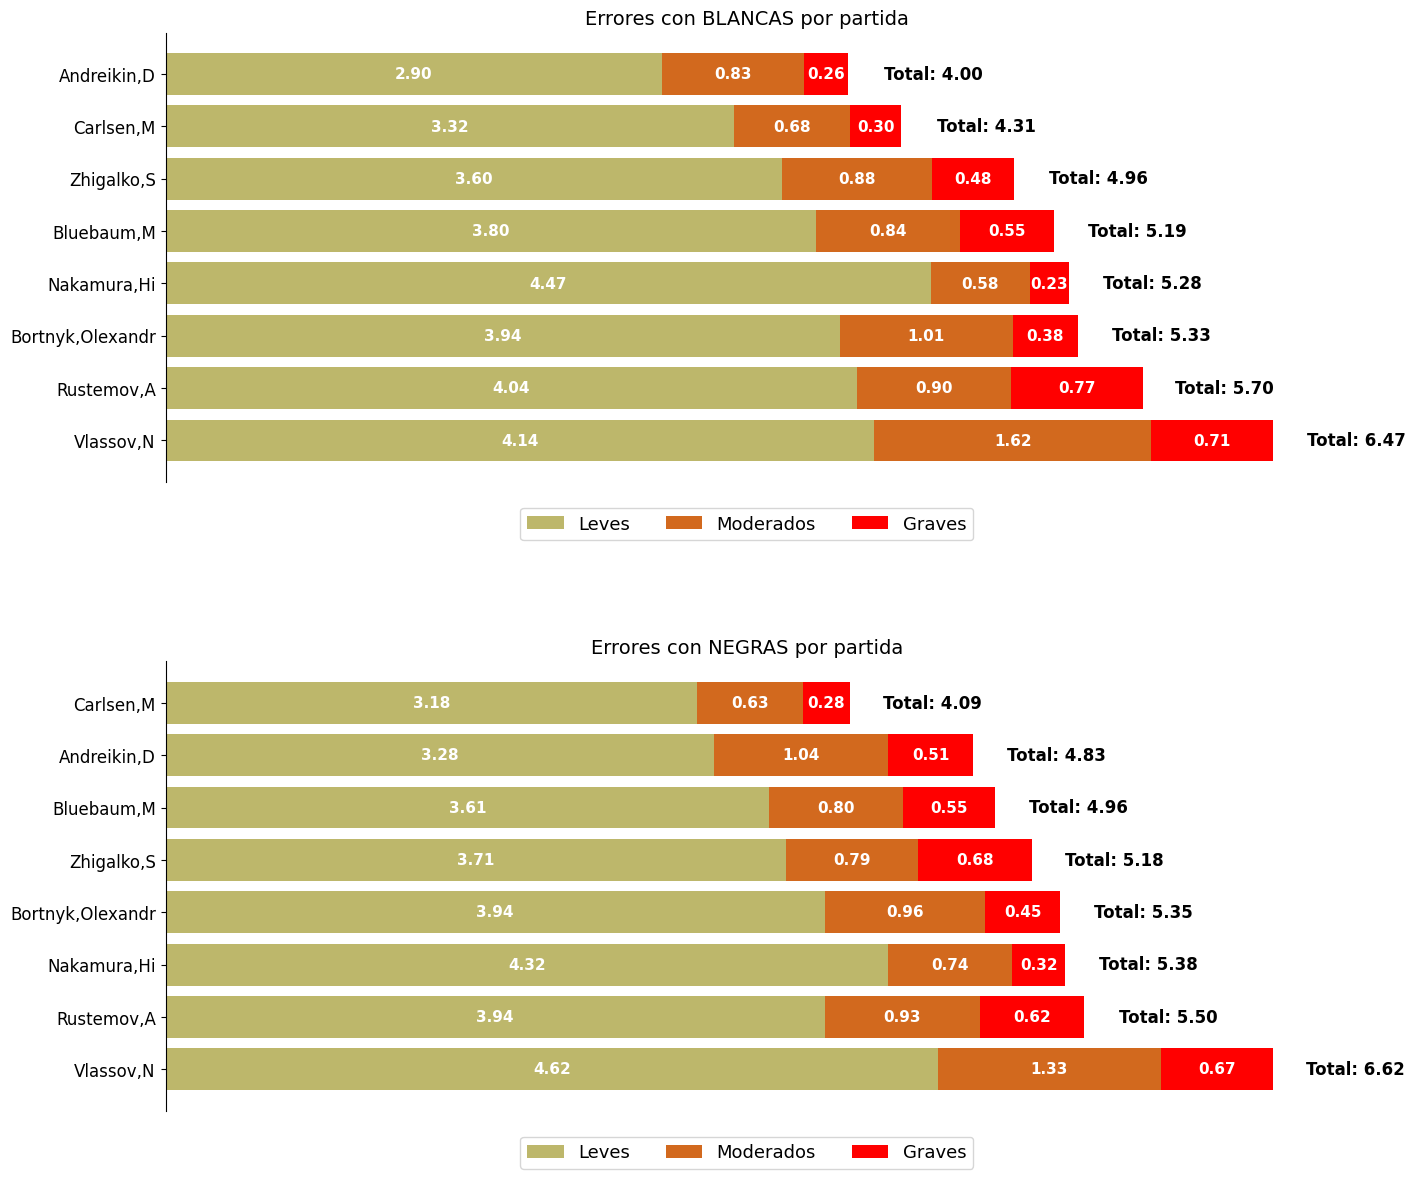

In [16]:
# 1. Preparar datos a partir del DataFrame Pandas (agrupado_pd ya convertido)
agrupado_pd = agrupado.toPandas()
agrupado_pd = agrupado_pd.set_index(["jugador", "color"])

# 2. Función para preparar datos
def preparar_datos_para_barras(df, color):
    data = df.xs(color, level="color").sort_values("Total/p")
    return data[["Leves/p", "Moderados/p", "Graves/p", "Total/p"]]

data_blancas = preparar_datos_para_barras(agrupado_pd, "W")
data_negras = preparar_datos_para_barras(agrupado_pd, "B")

# 3. Crear figura con GridSpec
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.4)
axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

# 4. Colores personalizados
colores = {
    "Leves/p": "darkkhaki",
    "Moderados/p": "chocolate",
    "Graves/p": "red"
}

# 5. Función para agregar etiquetas
def agregar_etiquetas(ax, y_pos, data, tipo, izquierda):
    for i, y in enumerate(y_pos):
        valor = data[tipo].iloc[i]
        izquierda_val = izquierda.iloc[i] if isinstance(izquierda, pd.Series) else izquierda[i]
        if valor > 0.05:
            x = izquierda_val + valor / 2
            ax.text(x, y, f"{valor:.2f}", ha='center', va='center', fontsize=11, color="white", weight="bold")

# 6. Dibujar cada gráfico
for ax, data, titulo_color in zip(axes, [data_blancas, data_negras], ["BLANCAS", "NEGRAS"]):
    jugadores = data.index.tolist()
    y_pos = range(len(jugadores))

    leves = data["Leves/p"]
    moderados = data["Moderados/p"]
    graves = data["Graves/p"]
    total = data["Total/p"]

    ax.barh(y_pos, leves, color=colores["Leves/p"], label="Leves")
    ax.barh(y_pos, moderados, left=leves, color=colores["Moderados/p"], label="Moderados")
    ax.barh(y_pos, graves, left=leves + moderados, color=colores["Graves/p"], label="Graves")

    agregar_etiquetas(ax, y_pos, data, "Leves/p", izquierda=pd.Series([0]*len(leves)))
    agregar_etiquetas(ax, y_pos, data, "Moderados/p", izquierda=leves)
    agregar_etiquetas(ax, y_pos, data, "Graves/p", izquierda=leves + moderados)

    for i, y in enumerate(y_pos):
        x = total.iloc[i] + 0.2
        ax.text(x, y, f"Total: {total.iloc[i]:.2f}", va='center', fontsize=12, color="black", weight="bold")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(jugadores, fontsize=12)
    ax.set_title(f"Errores con {titulo_color} por partida", fontsize=14)
    ax.invert_yaxis()
    ax.set_xticks([])

    # Estética
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=13)

# Guardar como imagen PNG
plt.savefig("errores_por_partida.png", dpi=400, bbox_inches='tight')

plt.show()


#### Análisis gráfico de los errores por fase. Gráficos de radar.

In [17]:
# Asegúrate de tener estos campos en tu DataFrame Spark:
# 'jugador', 'color', 'errores_apertura', 'errores_mediojuego', 'errores_final'

# --- Fase Spark: agregar por jugador y color ---
from pyspark.sql.functions import sum as _sum, count, col

fases = ["apertura", "mediojuego", "final"]
jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
]

columnas_error = [f"errores_{fase}" for fase in fases]

# Agrupar y resumir
df_radar = (
    df.filter(col("jugador").isin(jugadores_objetivo))
      .groupBy("jugador", "color")
      .agg(
          count("*").alias("partidas"),
          *[_sum(f"errores_{fase}").alias(f"errores_{fase}") for fase in fases]
      )
)

# Convertir a Pandas
df_radar_pd = df_radar.toPandas().set_index(["jugador", "color"])


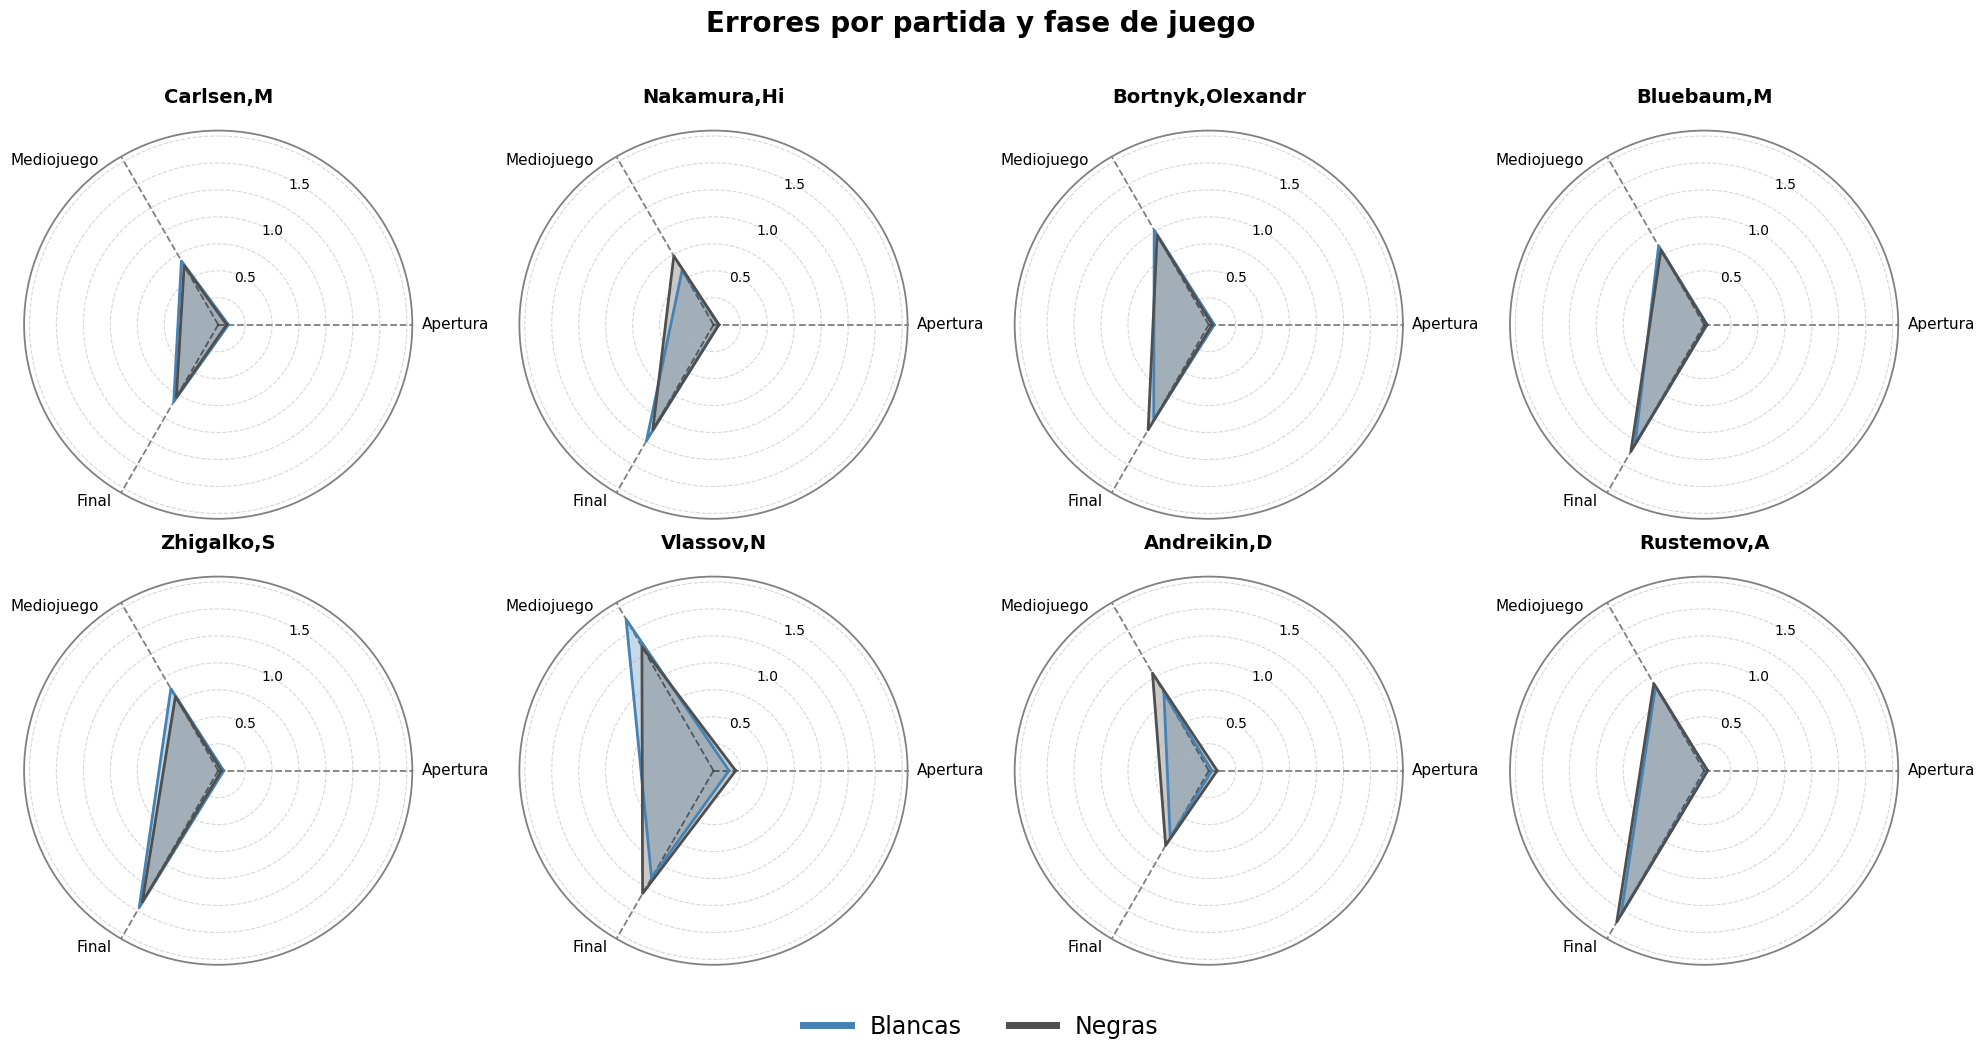

In [18]:
# Calcular errores por partida
for fase in fases:
    df_radar_pd[f"{fase}/p"] = df_radar_pd[f"errores_{fase}"] / df_radar_pd["partidas"]

# Radar config
labels = ["Apertura", "Mediojuego", "Final"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

colores = {"W": "#4682b4", "B": "#4f4f4f"}

# Crear figura
fig, axs = plt.subplots(2, 4, figsize=(20, 10), subplot_kw=dict(polar=True))   # 4x2
#fig, axs = plt.subplots(4, 2, figsize=(12, 18), subplot_kw=dict(polar=True))  # 2x4
fig.suptitle("Errores por partida y fase de juego", fontsize=20, fontweight="bold", y=1.02)
axs = axs.flatten()

# Dibujar radar por jugador
for idx, jugador in enumerate(jugadores_objetivo):
    ax = axs[idx]
    valores = {"W": [], "B": []}

    for color in ["W", "B"]:
        try:
            fila = df_radar_pd.loc[(jugador, color)]
            valores[color] = [fila[f"{fase}/p"] for fase in fases]
        except KeyError:
            valores[color] = [0.0, 0.0, 0.0]
        valores[color].append(valores[color][0])  # Cerrar círculo

    # Graficar
    ax.plot(angles, valores["W"], label="Blancas", color=colores["W"], linewidth=2)
    ax.fill(angles, valores["W"], color=colores["W"], alpha=0.3)

    ax.plot(angles, valores["B"], label="Negras", color=colores["B"], linewidth=2)
    ax.fill(angles, valores["B"], color=colores["B"], alpha=0.3)

    # Escala y etiquetas
    ax.set_ylim(0, 1.8)
    ax.set_yticks(np.arange(0.25, 1.85, 0.25))
    ax.set_yticklabels([""] * 7)

    for r in [0.5, 1.0, 1.5]:
        ax.text(np.pi / 3, r, f"{r:.1f}", ha="center", va="center", fontsize=10, color="black")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    ax.xaxis.grid(True, linestyle="--", color="black", linewidth=1.3)

    ax.spines["polar"].set_visible(True)
    ax.spines["polar"].set_color("gray")
    ax.spines["polar"].set_linewidth(1.3)

    ajustes_angulares = {"Apertura": 0, "Mediojuego": 15, "Final": -5}
    radios_etiquetas = {"Apertura": 2.2, "Mediojuego": 2.15, "Final": 2}

    for i, label in enumerate(labels):
        x = np.degrees(angles[i]) + ajustes_angulares[label]
        r = radios_etiquetas[label]
        ax.text(np.radians(x), r, label, ha="center", va="center", fontsize=11)

    ax.set_title(jugador, fontsize=14, fontweight="bold", pad=20)
    ax.grid(True, linestyle="--", alpha=0.5)

# Ocultar subplots vacíos si sobran
for j in range(len(jugadores_objetivo), len(axs)):
    fig.delaxes(axs[j])

# Leyenda global
legend_elements = [
    Line2D([0], [0], color=colores["W"], lw=5, label="Blancas"),
    Line2D([0], [0], color=colores["B"], lw=5, label="Negras")
]

fig.legend(handles=legend_elements, loc="lower center", ncol=2, fontsize=17, frameon=False, bbox_to_anchor=(0.5, -0.03))

plt.subplots_adjust(hspace=0.7)
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Ajuste manual del espacio vertical entre subplots
#plt.subplots_adjust(hspace=0.1, top=0.93, bottom=0.08)

# Guardar como imagen PNG
plt.savefig("errores_radar.png", dpi=400, bbox_inches='tight')
plt.show()


/tmp/ipykernel_29/2582338723.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 0.95])  # más espacio inferior para leyenda


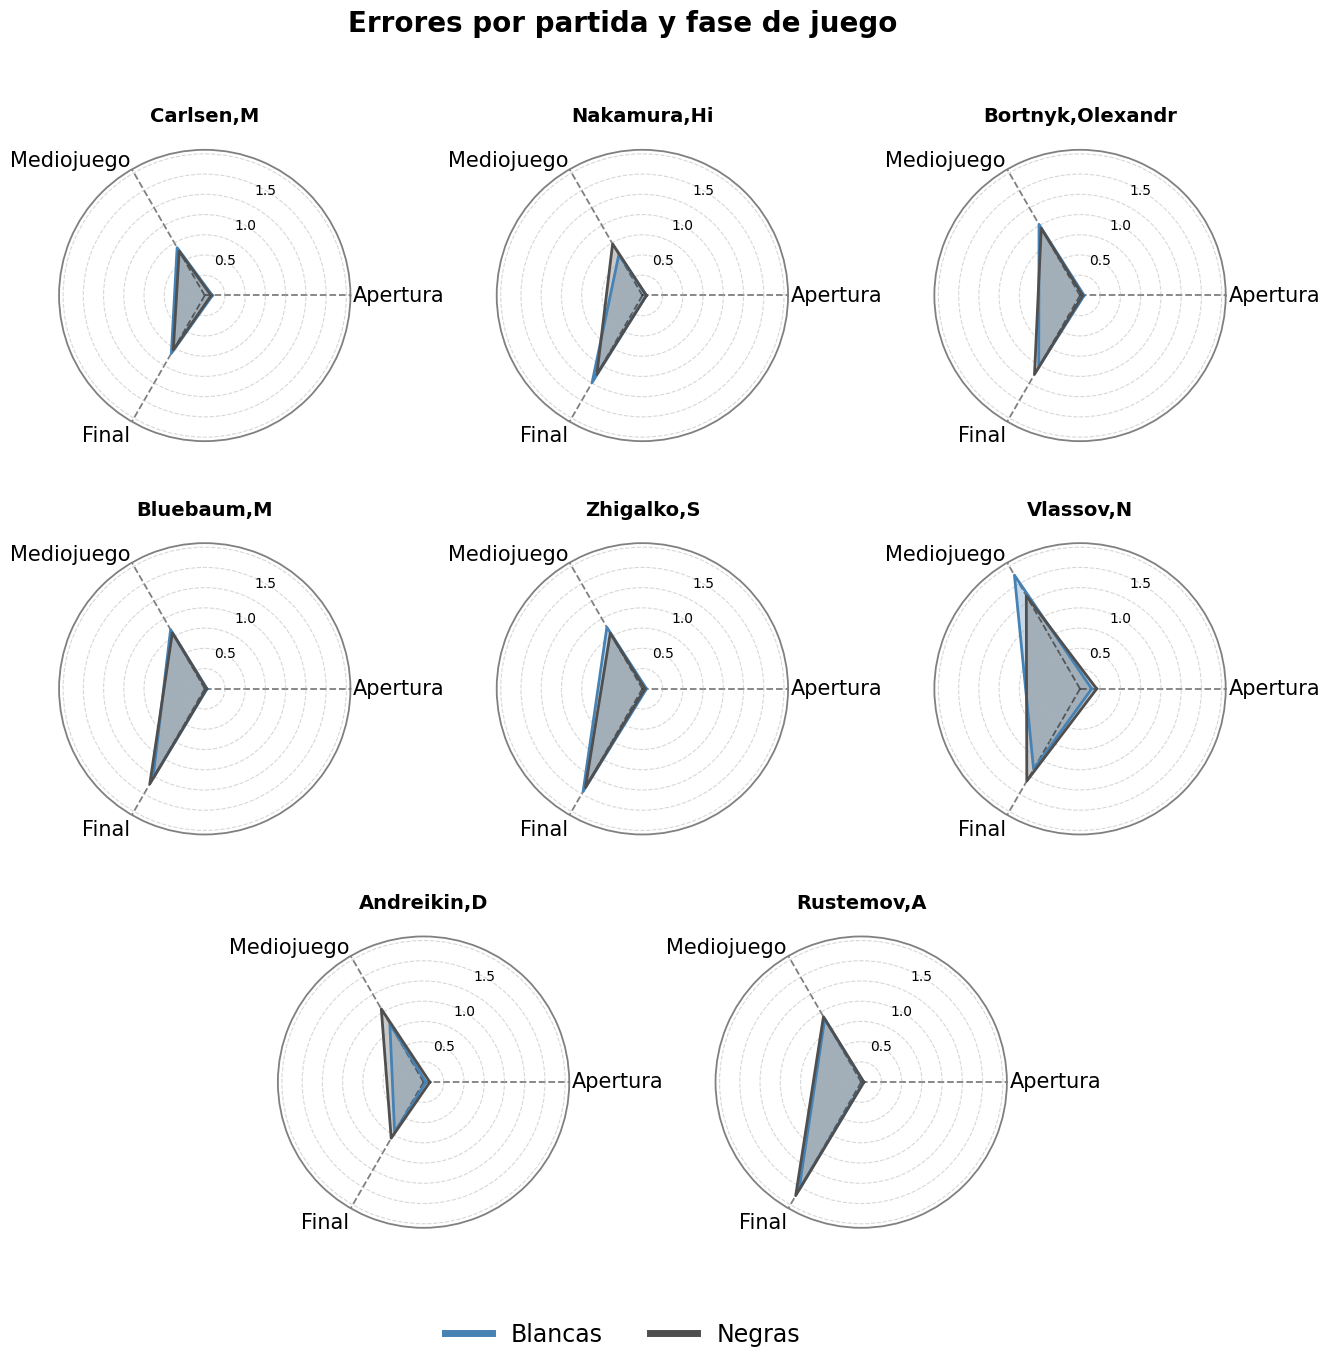

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D

# Configuración
labels = ["Apertura", "Mediojuego", "Final"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
colores = {"W": "#4682b4", "B": "#4f4f4f"}

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.35)  # más espacio entre filas
fig.suptitle("Errores por partida y fase de juego", fontsize=20, fontweight="bold", y=0.98)

# Coordenadas ajustadas
posiciones = [
    (0, 0), (0, 1), (0, 2),
    (1, 0), (1, 1), (1, 2),
    "centro_izq", "centro_der"
]

for idx, jugador in enumerate(jugadores_objetivo):
    if idx < 6:
        fila, col = posiciones[idx]
        ax = fig.add_subplot(gs[fila, col], polar=True)
    elif idx == 6:
        ax = fig.add_subplot(gs[2, 0:2], polar=True)  # primer gráfico centrado a la izquierda
    elif idx == 7:
        ax = fig.add_subplot(gs[2, 1:3], polar=True)  # segundo gráfico centrado a la derecha

    valores = {"W": [], "B": []}
    for color in ["W", "B"]:
        try:
            fila_data = df_radar_pd.loc[(jugador, color)]
            valores[color] = [fila_data[f"{fase}/p"] for fase in fases]
        except KeyError:
            valores[color] = [0.0, 0.0, 0.0]
        valores[color].append(valores[color][0])

    ax.plot(angles, valores["W"], label="Blancas", color=colores["W"], linewidth=2)
    ax.fill(angles, valores["W"], color=colores["W"], alpha=0.3)

    ax.plot(angles, valores["B"], label="Negras", color=colores["B"], linewidth=2)
    ax.fill(angles, valores["B"], color=colores["B"], alpha=0.3)

    ax.set_ylim(0, 1.8)
    ax.set_yticks(np.arange(0.25, 1.85, 0.25))
    ax.set_yticklabels([""] * 7)

    for r in [0.5, 1.0, 1.5]:
        ax.text(np.pi / 3, r, f"{r:.1f}", ha="center", va="center", fontsize=10, color="black")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    ax.xaxis.grid(True, linestyle="--", color="black", linewidth=1.3)

    ax.spines["polar"].set_visible(True)
    ax.spines["polar"].set_color("gray")
    ax.spines["polar"].set_linewidth(1.3)

    ajustes_angulares = {"Apertura": 0, "Mediojuego": 15, "Final": -5}
    radios_etiquetas = {"Apertura": 2.4, "Mediojuego": 2.35, "Final": 2.12}

    for i, label in enumerate(labels):
        x = np.degrees(angles[i]) + ajustes_angulares[label]
        r = radios_etiquetas[label]
        ax.text(np.radians(x), r, label, ha="center", va="center", fontsize=15)

    ax.set_title(jugador, fontsize=14, fontweight="bold", pad=20)
    ax.grid(True, linestyle="--", alpha=0.5)

# Leyenda global con más espacio abajo
legend_elements = [
    Line2D([0], [0], color=colores["W"], lw=5, label="Blancas"),
    Line2D([0], [0], color=colores["B"], lw=5, label="Negras")
]

fig.legend(handles=legend_elements, loc="lower center", ncol=2, fontsize=17, frameon=False, bbox_to_anchor=(0.5, 0.01))
plt.tight_layout(rect=[0, 0.07, 1, 0.95])  # más espacio inferior para leyenda

plt.savefig("errores_radar.png", dpi=400, bbox_inches='tight')
plt.show()


## 2.5 Estudio de las aperturas

In [20]:
# UDF para extraer ECO y apertura desde pgn
del col # elimina la definición de "col" anterior para que sea función de nuevo
from pyspark.sql.functions import col


def extraer_opening_eco(pgn):
    eco = opening = None
    if isinstance(pgn, str):
        match_eco = re.search(r'\[ECO "(.*?)"\]', pgn)
        match_opening = re.search(r'\[Opening "(.*?)"\]', pgn)
        if match_eco:
            eco = match_eco.group(1)
        if match_opening:
            opening = match_opening.group(1)
    return (eco, opening)

schema = StructType([
    StructField("cod_eco", StringType(), True),
    StructField("opening", StringType(), True),
])

extraer_udf = udf(extraer_opening_eco, schema)

# Aplicar a la columna `pgn`
df = df.withColumn("extraido", extraer_udf("pgn")) \
       .withColumn("cod_eco", col("extraido.cod_eco")) \
       .withColumn("opening", col("extraido.opening")) \
       .drop("extraido")


In [21]:
jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
]

df_filtrado = df.filter(col("jugador").isin(jugadores_objetivo))


In [22]:
from pyspark.sql.functions import count, sum as _sum, mean

agrupado = (
    df_filtrado.groupBy("jugador", "color", "cod_eco", "opening")
    .agg(
        count("*").alias("partidas"),
        _sum("errores_leves_apertura").alias("errores_leves"),
        _sum("errores_apertura").alias("errores_moderados"),
        _sum("errores_graves_apertura").alias("errores_graves"),
        mean("evaluacion_cp_apertura").alias("evaluacion_prom")
    )
)

agrupado_pd = agrupado.toPandas()


In [23]:
def generar_tablas_por_jugador(df, jugador):
    df_jugador = df[df["jugador"] == jugador]
    resultado = {}

    for color in ["W", "B"]:
        df_color = df_jugador[df_jugador["color"] == color]
        if df_color.empty:
            resultado[color] = pd.DataFrame()
            continue

        total = df_color["partidas"].sum()

        tabla = (
            df_color.groupby(["cod_eco", "opening"], as_index=False)
            .agg({
                "partidas": "sum",
                "errores_leves": "sum",
                "errores_moderados": "sum",
                "errores_graves": "sum",
                "evaluacion_prom": "mean"
            })
        )

        tabla["uso (%)"] = 100 * tabla["partidas"] / total
        tabla["errores_leves"] /= tabla["partidas"]
        tabla["errores_moderados"] /= tabla["partidas"]
        tabla["errores_graves"] /= tabla["partidas"]

        tabla = tabla.rename(columns={
            "opening": "apertura",
            "evaluacion_prom": "eval_cp_prom"
        })

        columnas = [
            "cod_eco", "apertura", "uso (%)", "eval_cp_prom",
            "errores_leves", "errores_moderados", "errores_graves"
        ]

        tabla = tabla[columnas].round(2).sort_values("uso (%)", ascending=False).reset_index(drop=True)

        resultado[color] = tabla

    return resultado


In [24]:
tablas_por_jugador = {
    jugador: generar_tablas_por_jugador(agrupado_pd, jugador)
    for jugador in jugadores_objetivo
}


In [25]:
tablas_por_jugador["Carlsen,M"]["W"].head(5)
# tablas_por_jugador["Nakamura,Hi"]["B"].head(5)


,cod_eco,apertura,uso (%),eval_cp_prom,errores_leves,errores_moderados,errores_graves
0,A45,Queen's pawn game,8.11,-3.51,0.08,0.0,0.0
1,A07,Reti,6.08,-2.35,0.11,0.0,0.0
2,D35,QGD,4.73,-0.86,0.00,0.0,0.0
3,A00,Van't Kruijs opening,3.38,-1.68,0.40,0.0,0.0
4,A06,Reti opening,2.70,-1.75,0.00,0.0,0.0


#### Aperturas más usadas (mapa de calor)

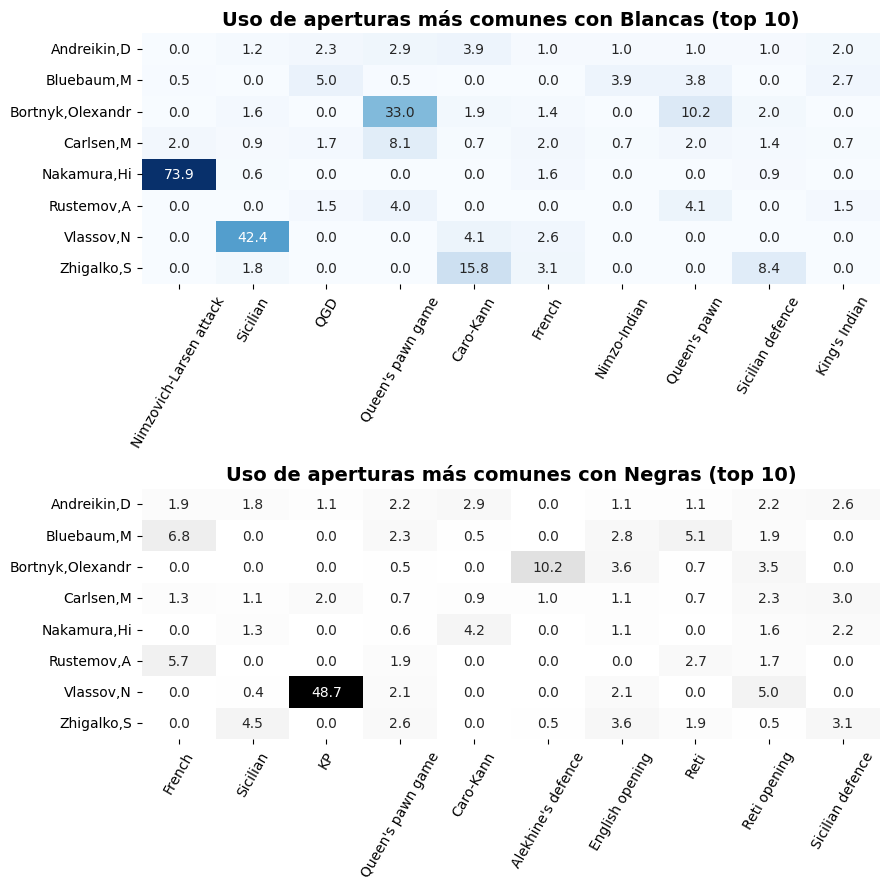

In [28]:
# 1. Unificar las tablas en un solo DataFrame
df_todo = []

for jugador, datos in tablas_por_jugador.items():
    for color in ['W', 'B']:
        tabla = datos[color]
        if tabla.empty:
            continue
        tabla = tabla.copy()
        tabla['jugador'] = jugador
        tabla['color'] = 'Blancas' if color == 'W' else 'Negras'
        df_todo.append(tabla)

df_aperturas = pd.concat(df_todo, ignore_index=True)

# 2. Separar por color
df_blancas = df_aperturas[df_aperturas['color'] == 'Blancas']
df_negras = df_aperturas[df_aperturas['color'] == 'Negras']

# 3. Top 10 aperturas más utilizadas por color
top_blancas = (
    df_blancas.groupby('apertura')['uso (%)']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

top_negras = (
    df_negras.groupby('apertura')['uso (%)']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# 4. Pivot para heatmaps
df_blancas_filtrado = df_blancas[df_blancas['apertura'].isin(top_blancas)]
df_negras_filtrado = df_negras[df_negras['apertura'].isin(top_negras)]

pivot_blancas = df_blancas_filtrado.pivot_table(
    index='jugador', columns='apertura', values='uso (%)', fill_value=0
)[top_blancas]

pivot_negras = df_negras_filtrado.pivot_table(
    index='jugador', columns='apertura', values='uso (%)', fill_value=0
)[top_negras]

# 5. Graficar heatmaps
fig, axes = plt.subplots(2, 1, figsize=(9, 9), sharex=False)

# Heatmap BLANCAS
sns.heatmap(
    pivot_blancas, annot=True, fmt=".1f", cmap="Blues",
    ax=axes[0], cbar=False
)
axes[0].set_title("Uso de aperturas más comunes con Blancas (top 10)", fontsize=14, weight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].tick_params(axis='x', rotation=60)

# Heatmap NEGRAS
sns.heatmap(
    pivot_negras, annot=True, fmt=".1f", cmap="Greys",
    ax=axes[1], cbar=False
)
axes[1].set_title("Uso de aperturas más comunes con Negras (top 10)", fontsize=14, weight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
# Guardar como imagen PNG
plt.savefig("aperturas.png", dpi=400, bbox_inches='tight')
plt.show()


## 6. Movimientos más habituales por pieza 

Mapa de calor de las piezas (según jugador, color y pieza) 

In [30]:
jugador_objetivo = "Carlsen,M"
color_objetivo = "W"      # "W" para blancas, "B" para negras
pieza_objetivo = "N"      # 'P', 'N', 'B', 'R', 'Q', 'K'

nombre_piezas = {
    "P": "Peón", "N": "Caballo", "B": "Alfil",
    "R": "Torre", "Q": "Dama", "K": "Rey"
}
nombre_pieza = nombre_piezas.get(pieza_objetivo, pieza_objetivo)

# Asegúrate de que 'san' esté disponible como columna en el DataFrame
df_san_pd = df.filter(
    (col("jugador") == jugador_objetivo) & (col("color") == color_objetivo)
).select("san").dropna().toPandas()


In [31]:
# Crear tablero vacío
tablero = np.zeros((8, 8))

# Función para extraer jugadas SAN
def extraer_jugadas(san):
    if isinstance(san, str):
        san_str = san.strip("[]").replace("'", "").replace("\n", " ")
        return san_str.split()
    elif isinstance(san, (list, np.ndarray)):
        return list(san)
    else:
        return []

# Procesar jugadas y registrar posiciones destino
for san_raw in df_san_pd["san"]:
    jugadas = extraer_jugadas(san_raw)
    for jugada in jugadas:
        jugada = jugada.replace("+", "").replace("#", "").replace("x", "").replace("=", "")
        
        if pieza_objetivo == "P":
            if re.fullmatch(r"[a-h][1-8]", jugada):
                col = ord(jugada[0]) - ord('a')
                row = 8 - int(jugada[1])
                tablero[row][col] += 1
        else:
            if jugada.startswith(pieza_objetivo) and len(jugada) >= 3:
                destino = jugada[-2:]
                if destino[0] in "abcdefgh" and destino[1] in "12345678":
                    col = ord(destino[0]) - ord('a')
                    row = 8 - int(destino[1])
                    tablero[row][col] += 1


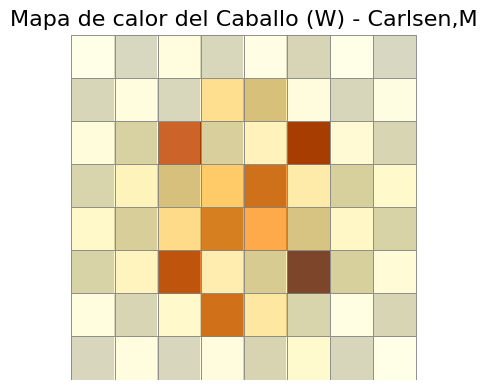

In [32]:
# Crear patrón de tablero (blanco/negro)
patron_tablero = np.add.outer(range(8), range(8)) % 2

fig, ax = plt.subplots(figsize=(4, 4))

# Fondo ajedrezado
ax.imshow(patron_tablero, cmap='binary', interpolation='none', extent=[0, 8, 0, 8], zorder=1)

# Mapa de calor superpuesto
sns.heatmap(
    tablero,
    cmap="YlOrBr",
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot=False,
    ax=ax,
    alpha=0.85,
    zorder=2
)

# Título
ax.set_title(f"Mapa de calor del {nombre_pieza} ({color_objetivo}) - {jugador_objetivo}", fontsize=16)

# Estética
ax.set_xlim(-0.01, 8.01)
ax.set_ylim(-0.01, 8.01)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()

# Guardar si se desea
# plt.savefig("tablero_calor.png", dpi=300, bbox_inches="tight")
# plt.savefig("tablero_calor.pdf", bbox_inches="tight")

plt.show()


#### Todos los jugadores, la misma pieza, comparación

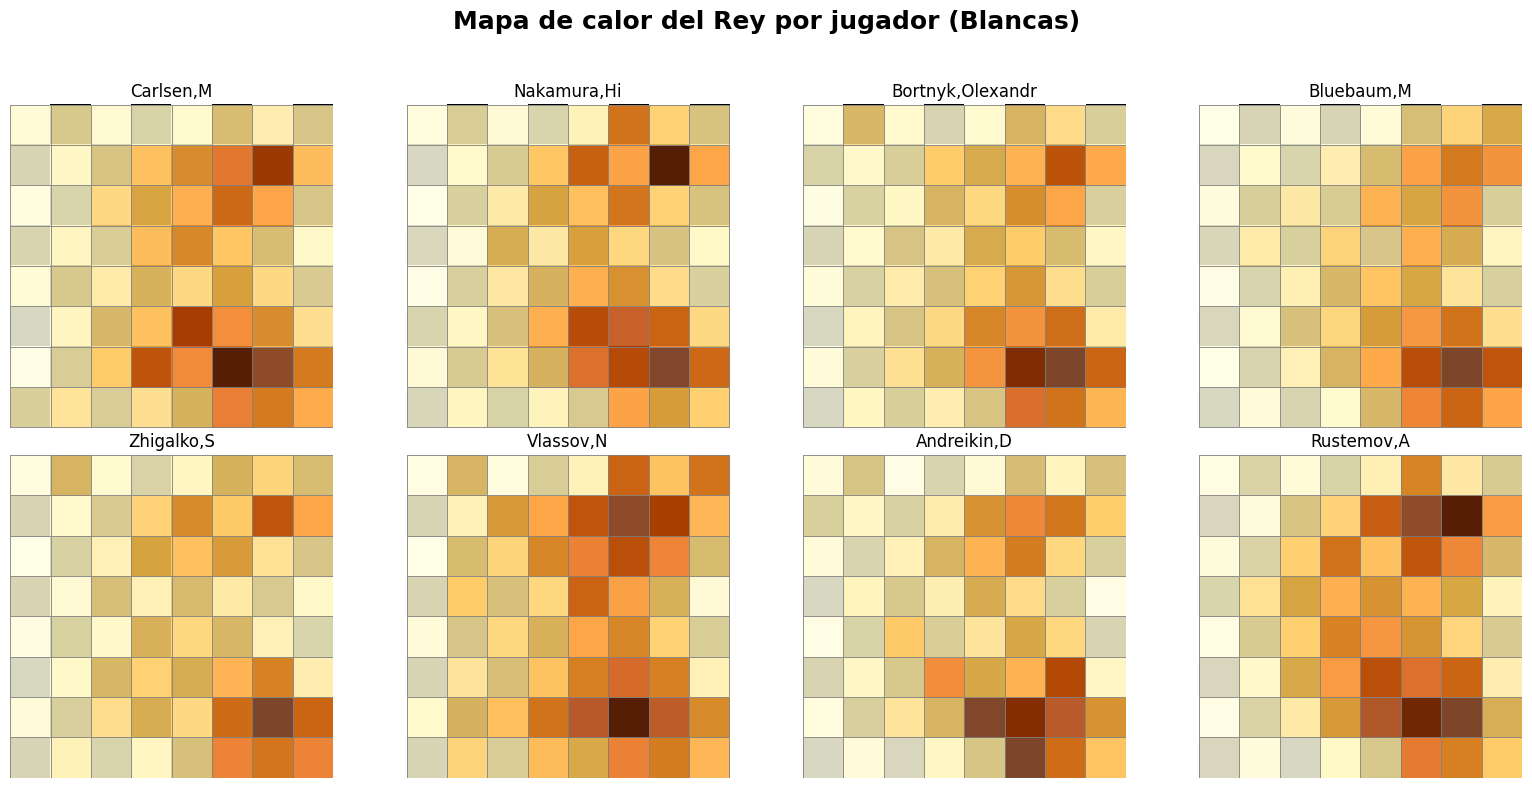

In [33]:
# Lista de jugadores
jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Bortnyk,Olexandr", "Bluebaum,M",
    "Zhigalko,S", "Vlassov,N", "Andreikin,D", "Rustemov,A"
]

color_objetivo = "W"  # "W" o "B"
pieza_objetivo = "K"  # 'P', 'N', 'B', 'R', 'Q', 'K'

nombre_piezas = {
    "P": "Peón", "N": "Caballo", "B": "Alfil",
    "R": "Torre", "Q": "Dama", "K": "Rey"
}
nombre_pieza = nombre_piezas.get(pieza_objetivo, pieza_objetivo)
nombre_color = "Blancas" if color_objetivo == "W" else "Negras"

def extraer_jugadas(san):
    if isinstance(san, str):
        san_str = san.strip("[]").replace("'", "").replace("\n", " ")
        return san_str.split()
    elif isinstance(san, (list, np.ndarray)):
        return list(san)
    else:
        return []

# Aseguramos que 'col' sea la función de PySpark
from pyspark.sql.functions import col as columna

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
patron_tablero = np.add.outer(range(8), range(8)) % 2

for i, jugador in enumerate(jugadores_objetivo):
    df_san_pd = df.filter(
        (columna("jugador") == jugador) & (columna("color") == color_objetivo)
    ).select("san").dropna().toPandas()

    tablero = np.zeros((8, 8))

    for san_raw in df_san_pd["san"]:
        jugadas = extraer_jugadas(san_raw)
        for jugada in jugadas:
            jugada = jugada.replace("+", "").replace("#", "").replace("x", "").replace("=", "")

            if pieza_objetivo == "P":
                if re.fullmatch(r"[a-h][1-8]", jugada):
                    col_idx = ord(jugada[0]) - ord('a')
                    row_idx = 8 - int(jugada[1])
                    tablero[row_idx][col_idx] += 1
            else:
                if jugada.startswith(pieza_objetivo) and len(jugada) >= 3:
                    destino = jugada[-2:]
                    if destino[0] in "abcdefgh" and destino[1] in "12345678":
                        col_idx = ord(destino[0]) - ord('a')
                        row_idx = 8 - int(destino[1])
                        tablero[row_idx][col_idx] += 1

    ax = axes[i]
    ax.imshow(patron_tablero, cmap='binary', interpolation='none', extent=[0, 8, 0, 8], zorder=1)

    sns.heatmap(
        tablero,
        cmap="YlOrBr",
        square=True,
        linewidths=0.5,
        linecolor='gray',
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        annot=False,
        ax=ax,
        alpha=0.85,
        zorder=2
    )

    ax.set_title(f"{jugador}", fontsize=12)
    ax.set_xlim(-0.01, 8.01)
    ax.set_ylim(-0.01, 8.01)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(f"Mapa de calor del {nombre_pieza} por jugador ({nombre_color})", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("tablero_calor.png", dpi=400, bbox_inches="tight")
plt.show()
